# Dark Souls II Reviews (2025)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Steam Reviews as of 3/26/25:

In [3]:
df = pd.read_csv('/kaggle/input/dark-souls-2-steam-reviews-2025/reviews.csv')
reviews = df.copy()
reviews = reviews.set_index('recommendationid')
reviews.drop(columns={'Unnamed: 0', 'in_early_access'}, inplace=True)

Converting date of review from unix:

In [4]:
reviews['month_name'] = pd.to_datetime(reviews.update_date, unit='s').dt.month_name()
reviews['month']      = pd.to_datetime(reviews.update_date, unit='s').dt.month
reviews['year']       = pd.to_datetime(reviews.update_date, unit='s').dt.year
reviews['day']        = pd.to_datetime(reviews.update_date, unit='s').dt.day

Focusing on just the English reviews:

In [5]:
reviews = reviews[reviews.language == 'english']

## Cleaning up the reviews

In [6]:
reviews = reviews.dropna(subset=['review'])
reviews.shape

(45563, 9)

In [7]:
reviews['review'] = reviews.review.str.lower()

In [8]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install --upgrade pip nltk

Note: you may need to restart the kernel to use updated packages.


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
stop_words.update(['dark', 'souls', 'soul', 'ds', 'scholar', 'first', 'sin', 'edition', 'game'])
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word.lower() not in stop_words])

In [12]:
reviews['review'] = (
        reviews['review']
        .str.lower()
        .str.replace(r'http\S+', '', regex=True)  # Remove URLs
        .str.replace(r'[^a-z]', ' ', regex=True)  # Keep only letters
        .str.replace(r'\b([a-z])\b', ' ', regex=True)  # Remove single letters
        .str.replace(r'\s+', ' ', regex=True)     # Replace multiple spaces with single space
        .str.strip()
    )

In [13]:
reviews['review'] = reviews.review.apply(remove_stopwords)

In [14]:
reviews

,review,language,init_date,update_date,voted_up,month_name,month,year,day
recommendationid,,,,,,,,,
190511148,dont give skeleton,english,1742267451,1742267451,True,March,3,2025,18
190504311,boia,english,1742259081,1742259081,True,March,3,2025,18
190502415,love pieces worst ever made soft somehow still...,english,1742256864,1742256864,True,March,3,2025,18
190501465,probably recommend awful iron passage frigid o...,english,1742255757,1742255757,True,March,3,2025,17
190500200,peak,english,1742254339,1742254339,True,March,3,2025,17
...,...,...,...,...,...,...,...,...,...
15162268,try tongue hole,english,1427932431,1428081346,True,April,4,2015,3
15162220,far good played mins far problems gb gb ddr ru...,english,1427932153,1427932153,True,April,4,2015,1
15162161,still died bonedrinker rufus keep streak alive,english,1427931845,1427931845,True,April,4,2015,1


For sake of analysis specifically on the actual reviews, drop any rows that have no reviews:

In [15]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [17]:
review_txt = reviews.review.values.flatten()
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

## Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews

Splitting the reviews by how many do and don't recommend buying the game:

In [18]:
pos_reviews = reviews[reviews['voted_up'] == True]
neg_reviews = reviews[reviews['voted_up'] == False]

In [19]:
pos_reviews.shape, neg_reviews.shape

((37387, 9), (8176, 9))

### Top2Vec:

In [20]:
%pip install top2vec

Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install --upgrade numpy gensim

  Using cached numpy-2.2.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Note: you may need to restart the kernel to use updated packages.


In [22]:
from top2vec import Top2Vec

In [23]:
docs = reviews['review'].tolist()
pos_docs = pos_reviews['review'].tolist()
neg_docs = neg_reviews['review'].tolist()

In [24]:
def topics(documents):
    mdl = Top2Vec(
        documents=documents,
        # contextual_top2vec=True,
        speed="learn",
        workers=8,
    )
    return mdl

In [25]:
# mdl = topics(docs)

In [26]:
# pos_mdl = topics(pos_docs)

In [27]:
# pos_topic_words, pos_word_scores, pos_topic_nums = pos_mdl.get_topics(pos_mdl.get_num_topics())
# pos_topic_words, pos_word_scores, pos_topic_nums

In [28]:
neg_mdl = topics(neg_docs)

2025-04-04 01:04:58,367 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-04 01:04:59,290 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-04-04 01:05:00,794 - top2vec - INFO - Creating joint document/word embedding


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

2025-04-04 01:05:06,018 - top2vec - INFO - Creating lower dimension embedding of documents
2025-04-04 01:05:34,458 - top2vec - INFO - Finding dense areas of documents
2025-04-04 01:05:34,732 - top2vec - INFO - Finding topics


In [29]:
neg_topic_words, neg_word_scores, neg_topic_nums = neg_mdl.get_topics(neg_mdl.get_num_topics())
neg_topic_words, neg_word_scores, neg_topic_nums

(array([['rpg', 'gameplay', 'bosses', ..., 'experience', 'mentioned',
         'difficulty'],
        ['bosses', 'boss', 'gameplay', ..., 'balanced', 'castle', 'arena'],
        ['gameplay', 'gaming', 'rpg', ..., 'developer', 'monsters',
         'challenging'],
        ...,
        ['play', 'playing', 'plays', ..., 'beat', 'turn', 'die'],
        ['outskirts', 'frigid', 'area', ..., 'wall', 'spawn', 'away'],
        ['steam', 'save', 'offline', ..., 'option', 'broken', 'issue']],
       dtype='<U14'),
 array([[0.41719252, 0.396992  , 0.3787919 , ..., 0.26629633, 0.26585886,
         0.2649346 ],
        [0.5814487 , 0.4416709 , 0.4115777 , ..., 0.30500668, 0.30443445,
         0.3039465 ],
        [0.52163714, 0.46894914, 0.44697404, ..., 0.32268724, 0.32267028,
         0.32255706],
        ...,
        [0.8137337 , 0.71341187, 0.6893876 , ..., 0.34458607, 0.3439054 ,
         0.34296313],
        [0.75933665, 0.62667805, 0.5022085 , ..., 0.26197055, 0.26177576,
         0.25951803],

In [30]:
neg_mdl.save("neg_topics_model")
neg_mdl = Top2Vec.load("neg_topics_model")

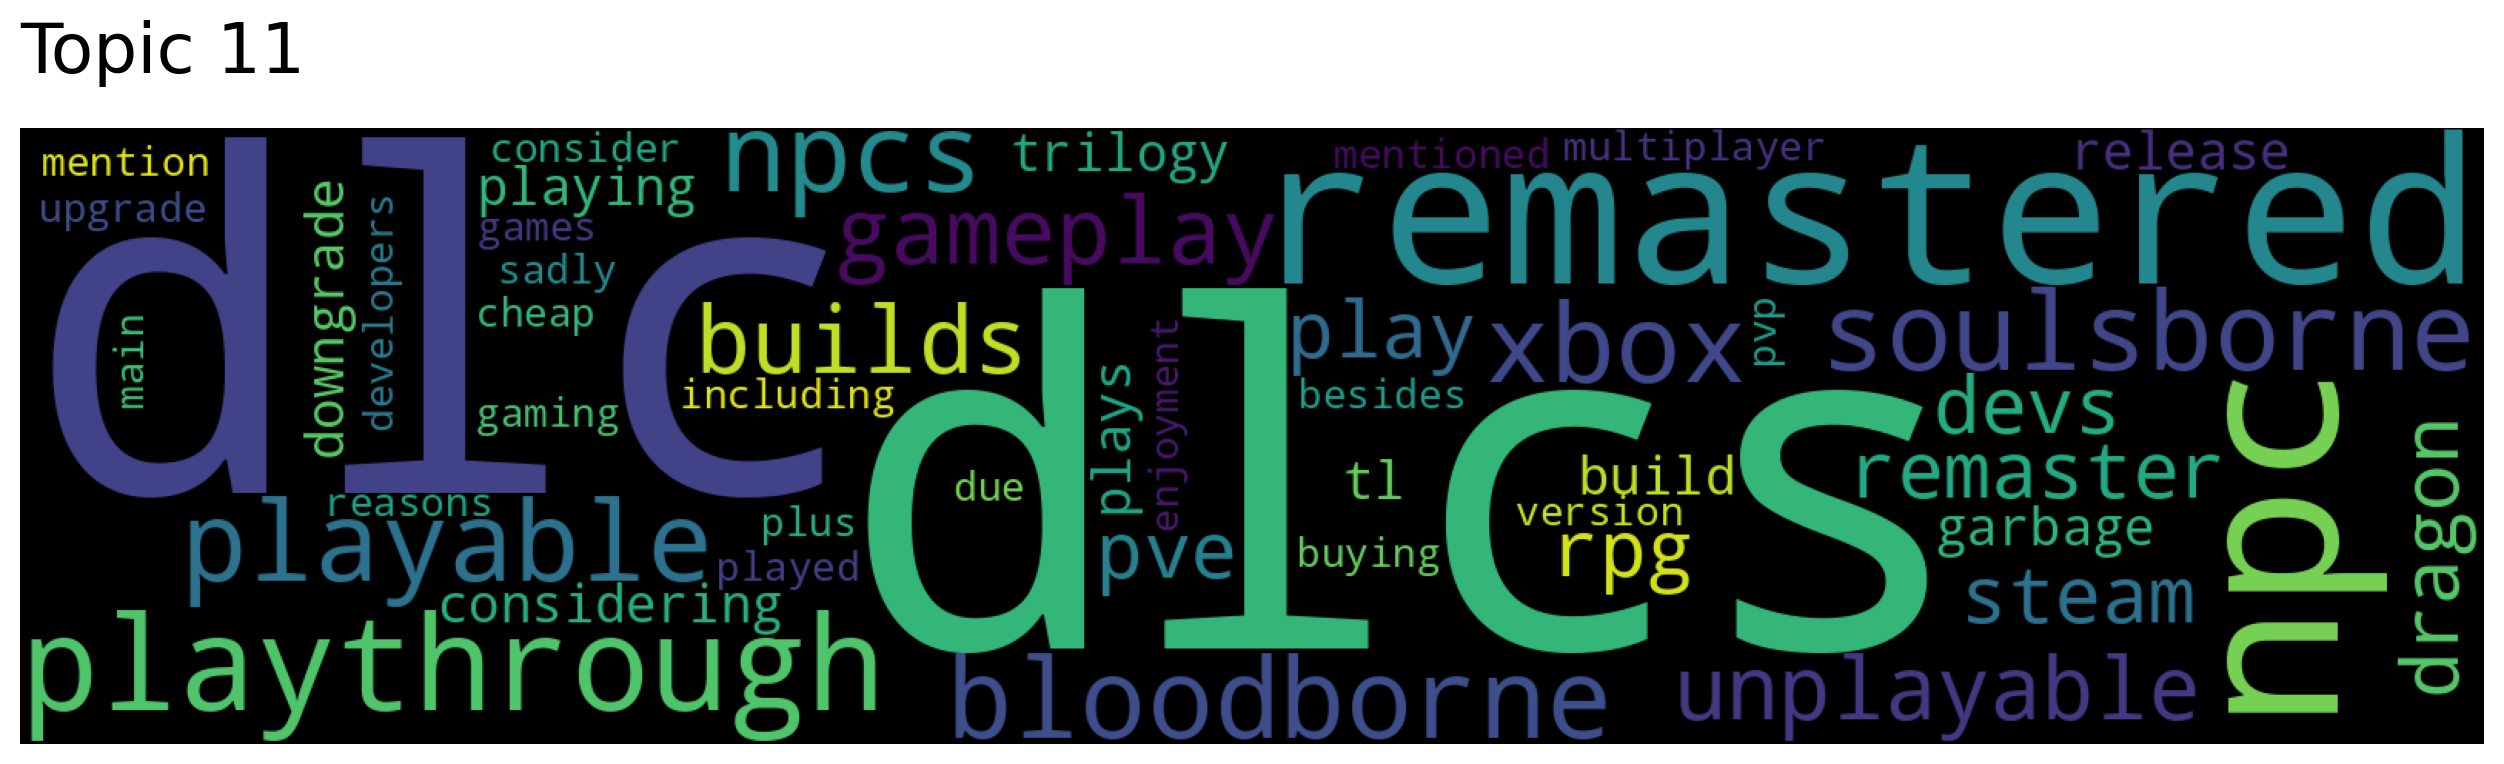

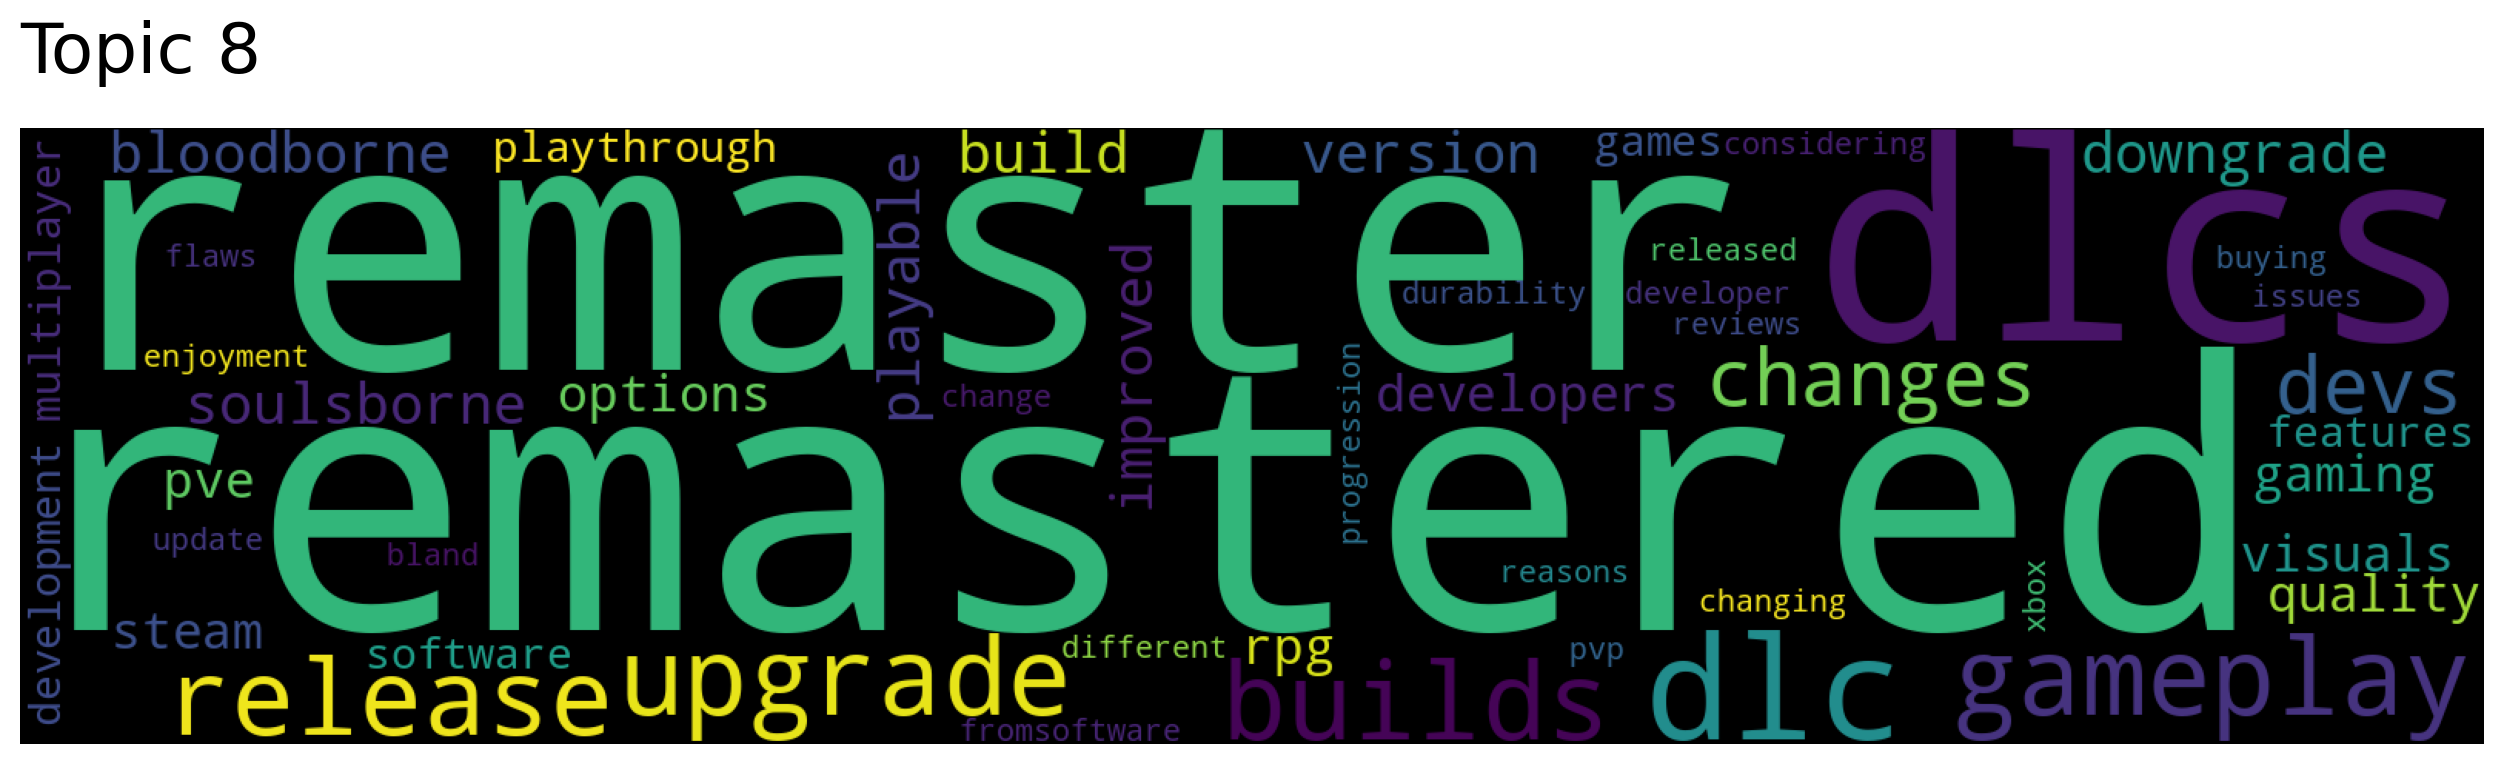

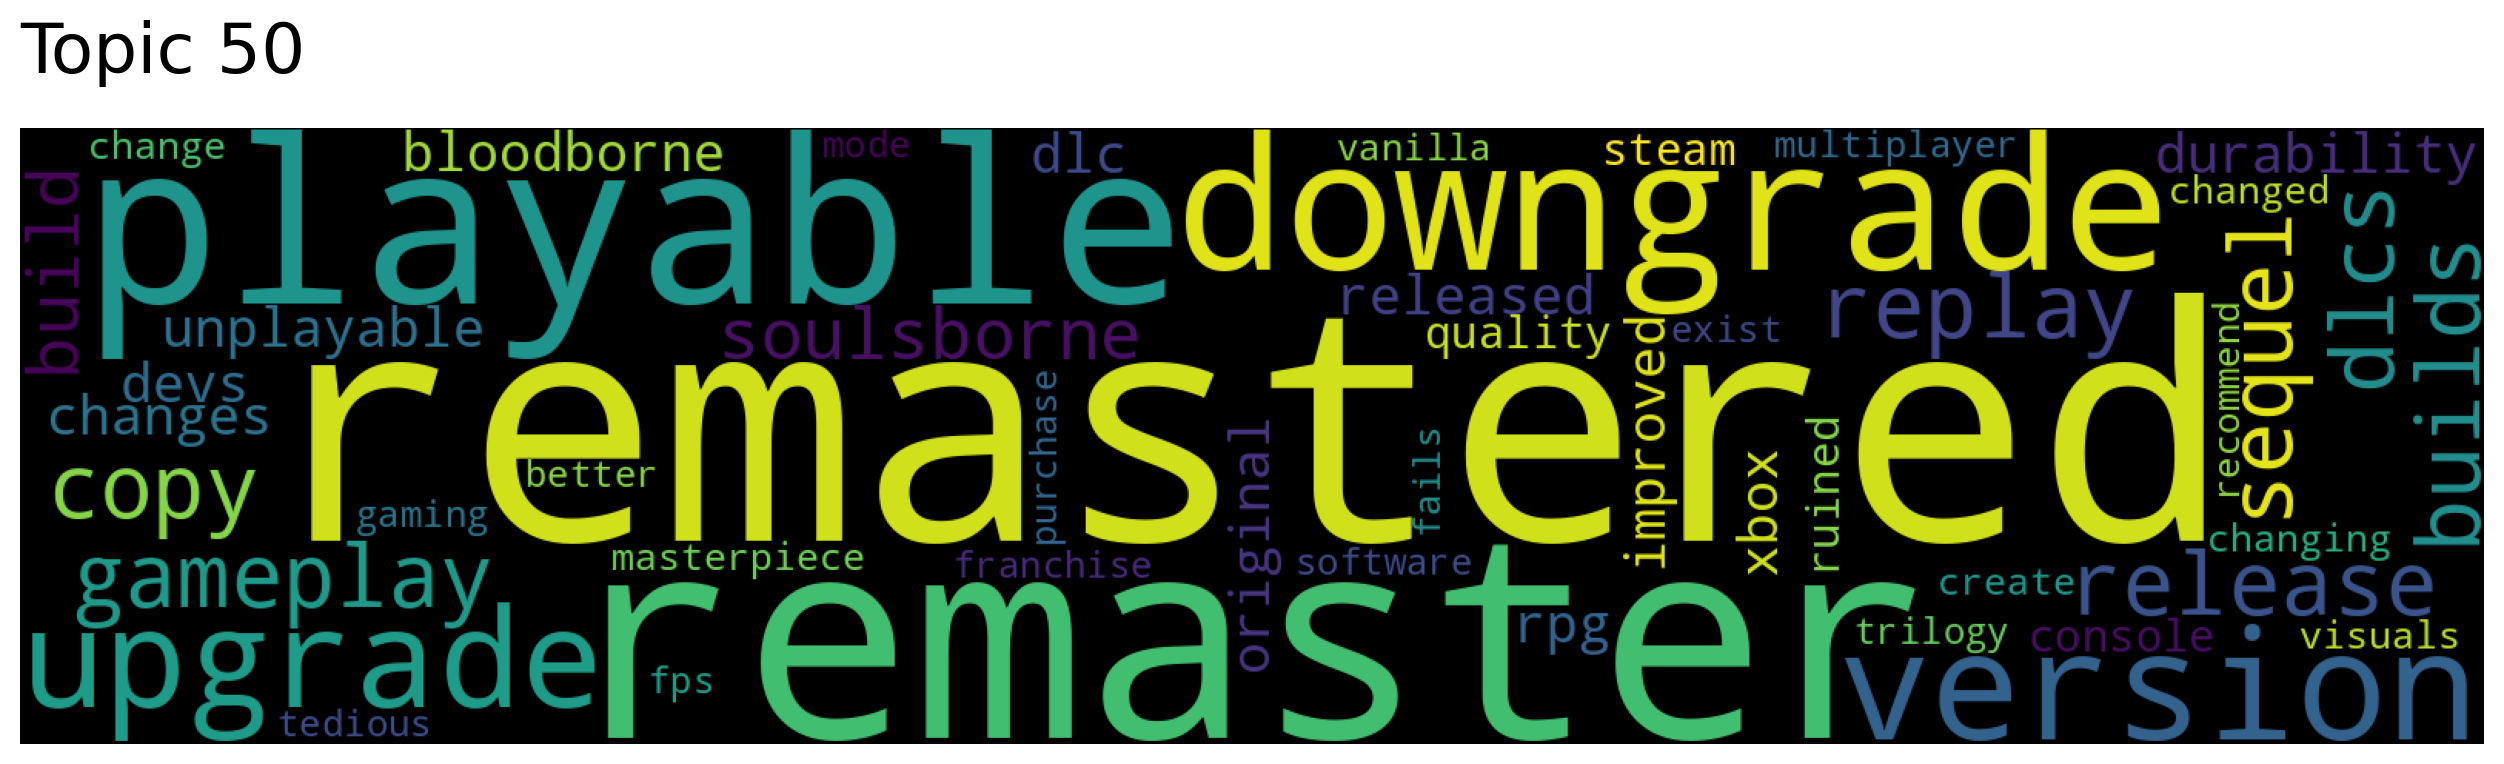

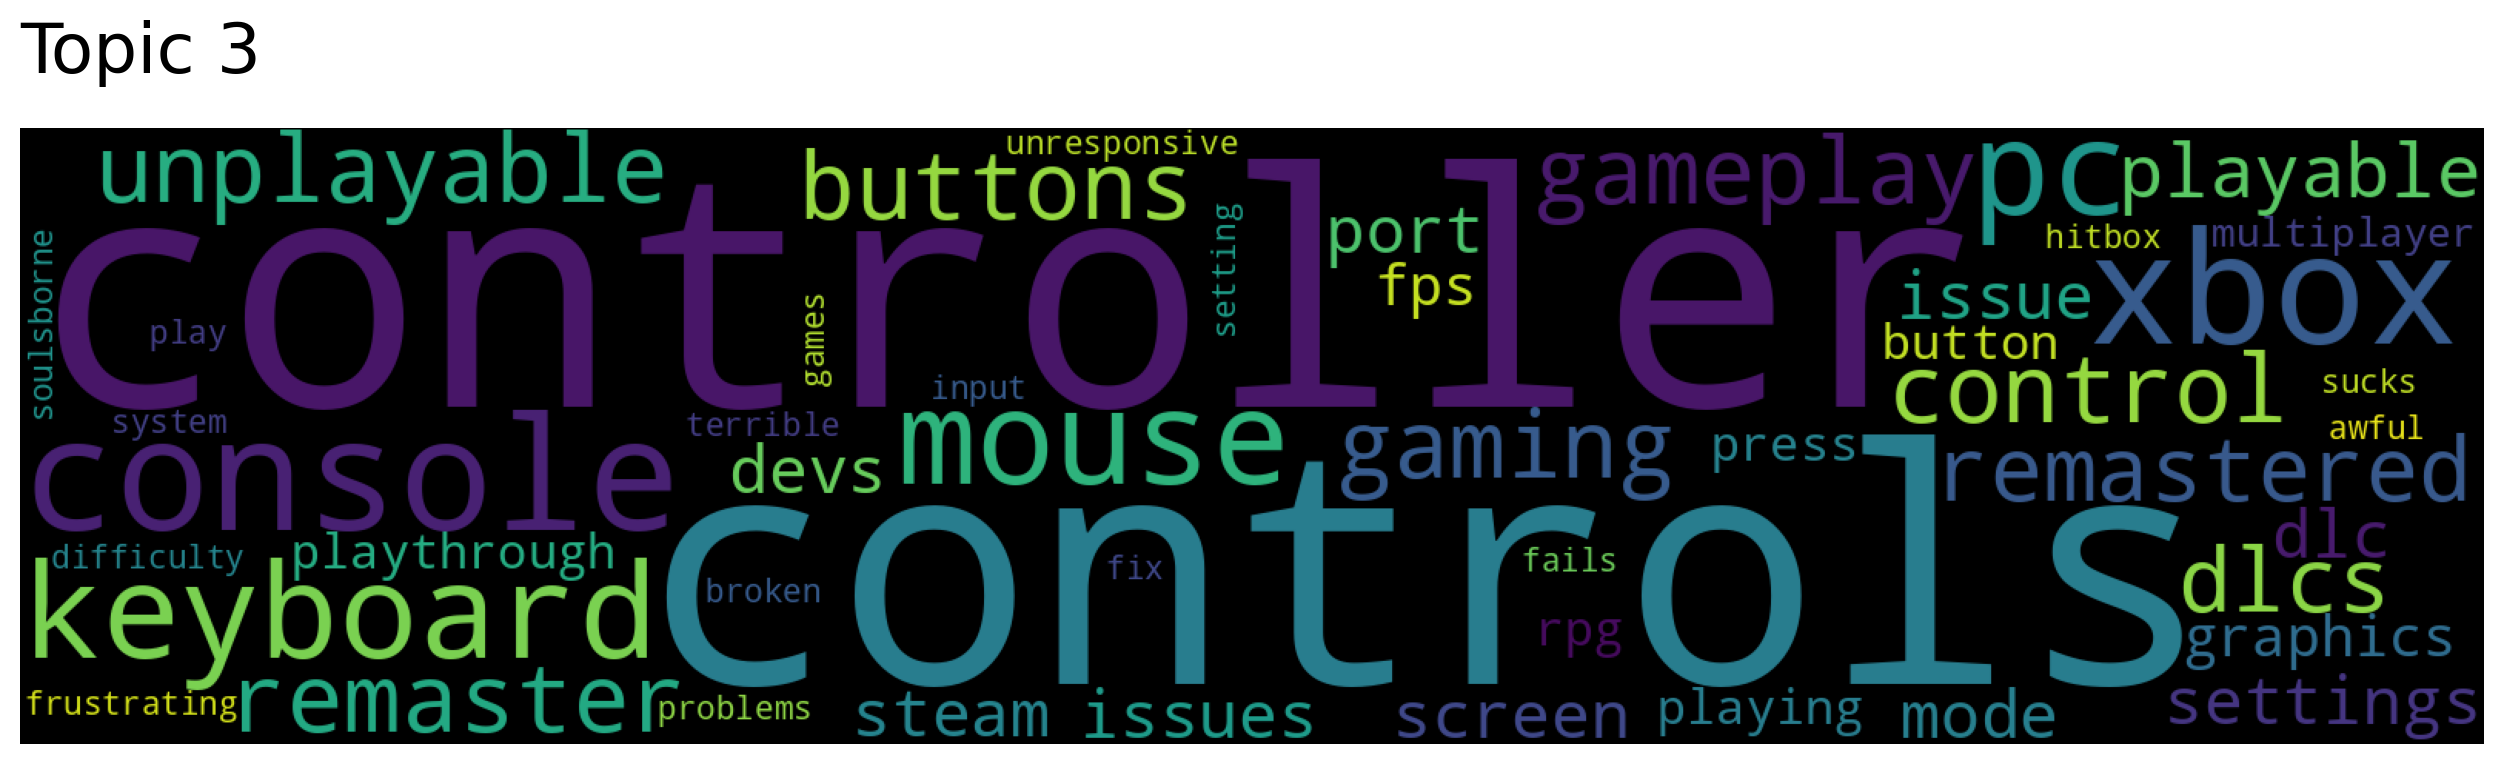

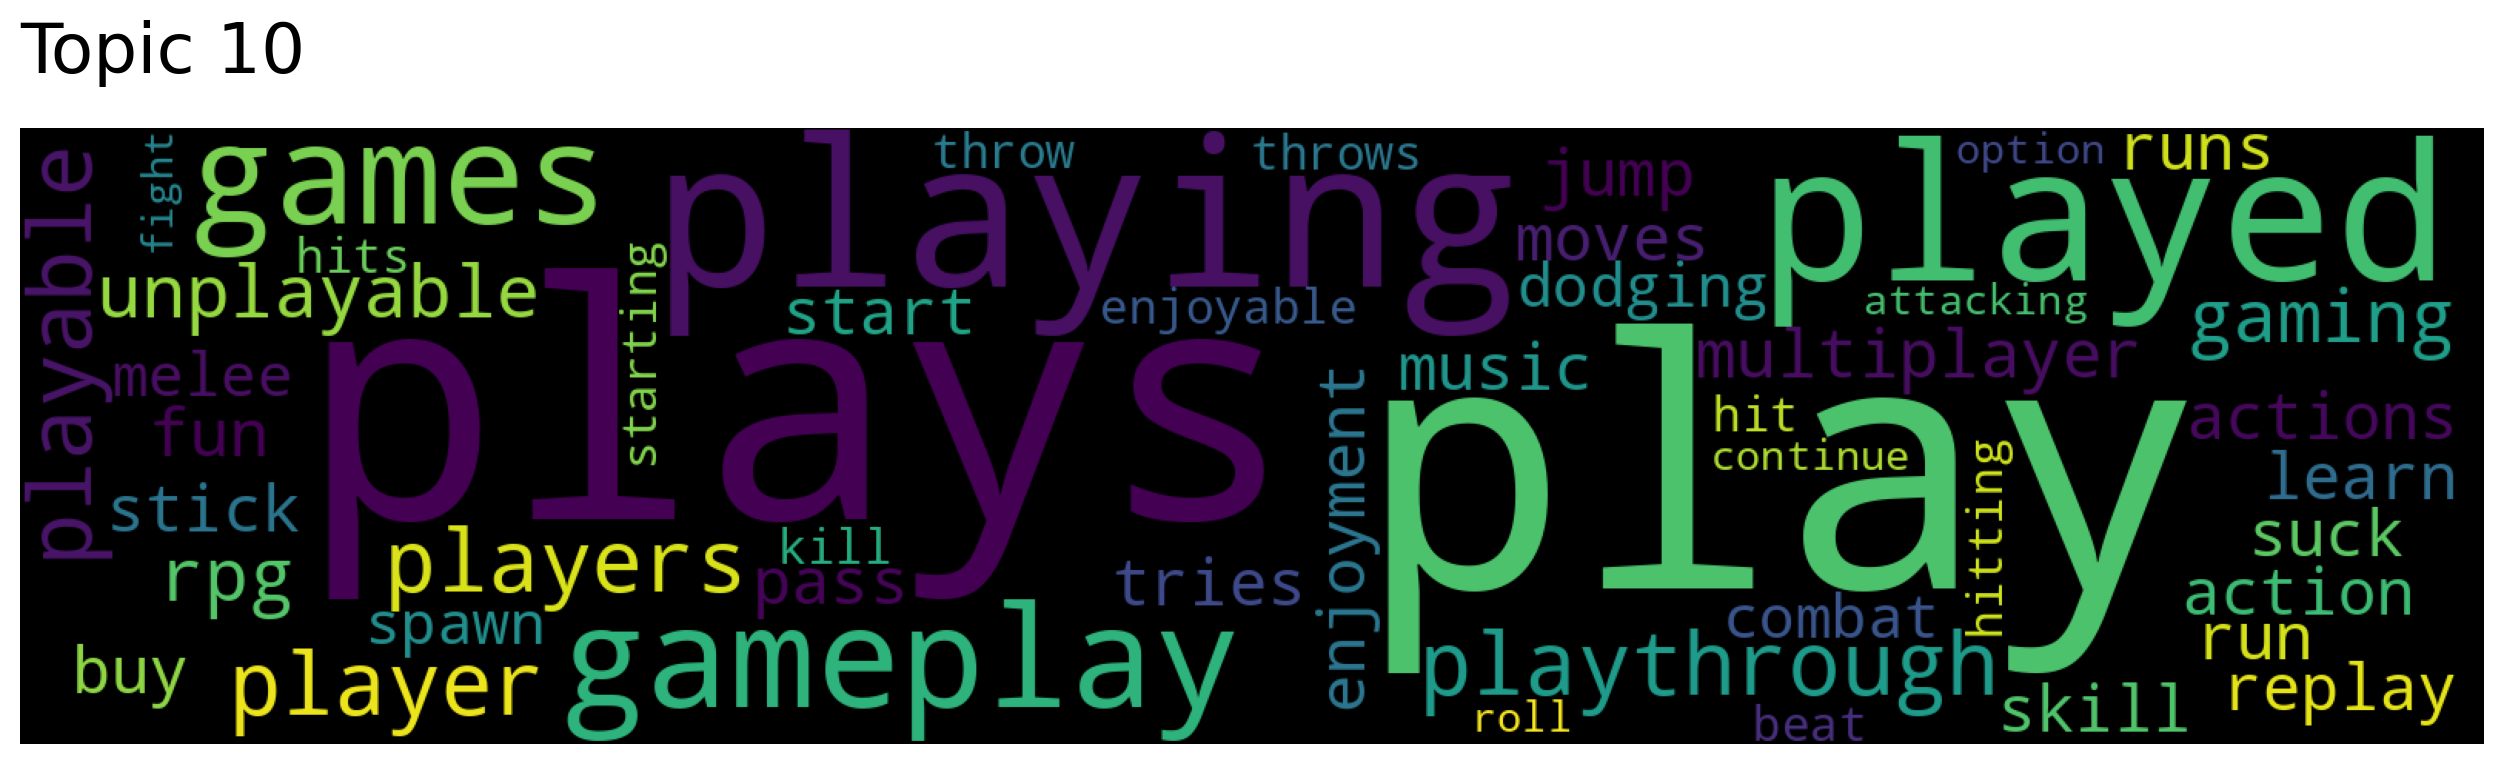

In [31]:
topic_words, word_scores, topic_scores, topic_nums = neg_mdl.search_topics(keywords=["dlc"], num_topics=5)
for topic in topic_nums:
    neg_mdl.generate_topic_wordcloud(topic)